# Background

Twitter is a micro-blogging social media platform with 217.5 million daily active users globally. With 500 million new tweets (posts) daily, the topics of these tweets varies widely – k-pop, politics, financial news… you name it! Individuals use it for news, entertainment, and discussions, while corporations use them to as a marketing tool to reach out to a wide audience. Given the freedom Twitter accords to its user, Twitter can provide a conducive environment for productive discourse, but this freedom can also be abused, manifesting in the forms of racism and sexism.

# Problem Statement

With Twitter’s significant income stream coming from advertisers, it is imperative that Twitter keeps a substantial user base. On the other hand, Twitter should maintain a safe space for users and provide some level of checks for the tweets the users put out into the public space, and the first step would be to identify tweets that espouse racist or sexist ideologies, and then Twitter can direct the users to appropriate sources of information where users can learn more about the community that they offend or their subconscious biases so they will be more aware of their racist/sexist tendencies. Thus, to balance, Twitter has to be accurate in filtering inappropriate tweets from innocuous ones, and the kind of inappropriateness of flagged tweets (tag - racist or sexist).

F1-scores will be the primary metric as it looks at both precision and recall, each looking at false positives (FPs) and false negatives (FNs) respectively, and is a popular metric for imbalanced data as is the case with the dataset used.

For the purpose of explanation, racist tweets are used as the ‘positive’ case.

In this context, FPs are the cases where the model erroneously flags out tweets as racist when the tweet is actually innocuous/sexist. FNs are cases where the model erroneously flags out tweets as innocuous/sexist but the tweets are actually racist.

Thus, higher F1-scores are preferred.

# Importing Libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# For NLP data cleaning and preprocessing
import re, string, nltk, itertools
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import demoji

In [2]:
# Changing display settings
pd.set_option('display.max_row', 100)
pd.set_option('display.max_colwidth', None)

# Importing training dataset

In [3]:
twitter_final = pd.read_csv('../Capstone/data/twitter_final.csv')

In [4]:
twitter_final.head()

,Text,Annotation,oh_label
0,@halalflaws @biebervalue @greenlinerzjm I read them in context.No change in meaning. The history of Islamic slavery. https://t.co/xWJzpSodGj,none,0
1,@ShreyaBafna3 Now you idiots claim that people who tried to stop him from becoming a terrorist made him a terrorist. Islamically brain dead.,none,0
2,"RT @Mooseoftorment Call me sexist, but when I go to an auto place, I'd rather talk to a guy",sexism,1
3,"@g0ssipsquirrelx Wrong, ISIS follows the example of Mohammed and the Quran exactly.",racism,1
4,#mkr No No No No No No,none,0


In [5]:
twitter_final.shape

(16849, 3)

In [6]:
twitter_final.Annotation.value_counts()

none      11501
sexism     3378
racism     1970
Name: Annotation, dtype: int64

# Cleaning/Preprocessing

There is a need to preprocess and clean the texts before conducting EDA.

The cleaning/ preprocessing steps include:
* Removing emojis 😁
* Removing hashtags (mentions), and URLs
* Converting all text to lowercase
* Removing contractions
* Removing punctuations
* Removing back-to-back spaces
* Updating stopwords (done iteratively upon looking at word n-gram results)
* Removing stopwords

In [7]:
# Instantiating stopwords
Stopwords = set(stopwords.words('english'))

In [8]:
# Updating Stopwords
Stopwords.update(['rt','amp'])

# Creating functions for data cleaning

### Creating a function for text cleaning (stemming)

In [9]:
def clean_text_stem(text):
    # Removing emojis
    dem = demoji.findall(text)
    for item in dem.keys():
        text = text.replace(item,'')
        
    # Removing mentions and URLs
    pattern = re.compile(r"(@[A-Za-z0-9]+|_[A-Za-z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+)")
    text = pattern.sub('', text)
    text = " ".join(text.split())
    
    # Making text lowercase
    text = text.lower()
    
    # Decontracting constracted words
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    # Removing punctuations
    remove_punc = re.compile(r"[%s]" % re.escape(string.punctuation))
    text = remove_punc.sub('', text)
    
    # Stemming words
    tokenized = nltk.word_tokenize(text)
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(words) for words in tokenized])
    
    # Removing back-to-back spaces
    text = re.sub("\s\s+" , " ", text)
    
    # Removing stopwords
    text = " ".join([word for word in str(text).split() if word not in Stopwords])
    
    return text

### Creating a function for text cleaning (lemmatizing)

In [10]:
def clean_text_lemmatize(text):
    # Removing emojis
    dem = demoji.findall(text)
    for item in dem.keys():
        text = text.replace(item,'')
        
    # Removing mentions and URLs
    pattern = re.compile(r"(@[A-Za-z0-9]+|_[A-Za-z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+|)")
    text = pattern.sub('', text)
    text = " ".join(text.split())
    
    # Making text lowercase
    text = text.lower()
    
    # Decontracting constracted words
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    # Removing punctuations
    remove_punc = re.compile(r"[%s]" % re.escape(string.punctuation))
    text = remove_punc.sub('', text)
    
    # Lemmatizing
    # To retrieve the appropriate part-of-speech (POS) tagging for each word in a sentence/tweet for the usage of WordNetLemmatizer
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in str(text).split()]
    text = ' '.join(text)
    
    # Removing back-to-back spaces
    text = re.sub("\s\s+" , " ", text)
    
    # Removing stopwords
    text = " ".join([word for word in str(text).split() if word not in Stopwords])
    
    return text

### Creating 2 columns, one preprocessed using Porter Stemming and another using WordNet Lemmatization

In [11]:
twitter_final['Text_stem'] = twitter_final['Text'].apply(lambda text: clean_text_stem(text))

In [12]:
twitter_final['Text_lemm'] = twitter_final['Text'].apply(lambda text: clean_text_lemmatize(text))

In [13]:
twitter_final.head(10)

,Text,Annotation,oh_label,Text_stem,Text_lemm
0,@halalflaws @biebervalue @greenlinerzjm I read them in context.No change in meaning. The history of Islamic slavery. https://t.co/xWJzpSodGj,none,0,read contextno chang mean histori islam slaveri,read contextno change meaning history islamic slavery
1,@ShreyaBafna3 Now you idiots claim that people who tried to stop him from becoming a terrorist made him a terrorist. Islamically brain dead.,none,0,idiot claim peopl tri stop becom terrorist made terrorist islam brain dead,idiot claim people try stop become terrorist make terrorist islamically brain dead
2,"RT @Mooseoftorment Call me sexist, but when I go to an auto place, I'd rather talk to a guy",sexism,1,call sexist go auto place would rather talk guy,call sexist go auto place would rather talk guy
3,"@g0ssipsquirrelx Wrong, ISIS follows the example of Mohammed and the Quran exactly.",racism,1,wrong isi follow exampl moham quran exactli,wrong isi follow example mohammed quran exactly
4,#mkr No No No No No No,none,0,mkr,mkr
5,RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Saudi preacher who 'raped and tortured' his five -year-old daughter to death is released after …,none,0,saudi preacher rape tortur hi five yearold daughter death releas …,saudi preacher rap torture five yearold daughter death release …
6,RT @Millhouse66 @Maureen_JS nooo not sexist but most women are bad drivers,sexism,1,nooo sexist women bad driver,nooo sexist woman bad driver
7,Going to make some pancakes.....Don't hve any strawberries ....🍓🍓🍓🍓but I hve bananas .....🍌🍌🍌🍌. ;))) #MKR,none,0,go make pancakesdo hve ani strawberri hve banana mkr,go make pancakesdo hve strawberry hve banana mkr
8,RT @ahtweet: @freebsdgirl How dare you have feelings is a fantastic way to dehumanize someone.,none,0,dare feel fantast way dehuman someon,dare feeling fantastic way dehumanize someone
9,RT @Newmanzaa: There's something wrong when a girl wins Wayne Rooney street striker #NotSexist,sexism,1,someth wrong girl win wayn rooney street striker notsexist,something wrong girl win wayne rooney street striker notsexist


In [14]:
twitter_final.head(4)

,Text,Annotation,oh_label,Text_stem,Text_lemm
0,@halalflaws @biebervalue @greenlinerzjm I read them in context.No change in meaning. The history of Islamic slavery. https://t.co/xWJzpSodGj,none,0,read contextno chang mean histori islam slaveri,read contextno change meaning history islamic slavery
1,@ShreyaBafna3 Now you idiots claim that people who tried to stop him from becoming a terrorist made him a terrorist. Islamically brain dead.,none,0,idiot claim peopl tri stop becom terrorist made terrorist islam brain dead,idiot claim people try stop become terrorist make terrorist islamically brain dead
2,"RT @Mooseoftorment Call me sexist, but when I go to an auto place, I'd rather talk to a guy",sexism,1,call sexist go auto place would rather talk guy,call sexist go auto place would rather talk guy
3,"@g0ssipsquirrelx Wrong, ISIS follows the example of Mohammed and the Quran exactly.",racism,1,wrong isi follow exampl moham quran exactli,wrong isi follow example mohammed quran exactly


Based on the top 10 results, it is observed that the emojis, mentions of other twitter users, URLs, hashtags are removed and letters are made lowercase.

In [15]:
# Creating a column showing length of cleaned text
twitter_final['Text_stem_length'] = twitter_final['Text_stem'].str.len()
twitter_final['Text_lemm_length'] = twitter_final['Text_lemm'].str.len()

### Checking for and Filtering out empty rows after Cleaning

In [16]:
twitter_final_stem_0 = twitter_final.loc[twitter_final['Text_stem_length'] == 0]
twitter_final_stem_0.shape[0]

296

Of the stemmed tweets, there are 296 empty rows after cleaning.

In [17]:
twitter_final_lemm_0 = twitter_final.loc[twitter_final['Text_lemm_length'] == 0]
twitter_final_lemm_0.shape[0]

306

Of the lemmatized tweets, there are 306 empty rows after cleaning.

In [18]:
twitter_final_stem_0.head(3)

,Text,Annotation,oh_label,Text_stem,Text_lemm,Text_stem_length,Text_lemm_length
154,"@gamer456ism @femfreq @StephenAtHome ""you're""",none,0,,,0,0
179,@dankmtl @PeaceNotHate_ http://t.co/HxgNJvWoqG,none,0,,,0,0
211,@Assiye61 http://t.co/dduX3ZbMtE,none,0,,,0,0


In [19]:
twitter_final_lemm_0.head(3)

,Text,Annotation,oh_label,Text_stem,Text_lemm,Text_stem_length,Text_lemm_length
154,"@gamer456ism @femfreq @StephenAtHome ""you're""",none,0,,,0,0
179,@dankmtl @PeaceNotHate_ http://t.co/HxgNJvWoqG,none,0,,,0,0
211,@Assiye61 http://t.co/dduX3ZbMtE,none,0,,,0,0


It can be observed that the now empty rows were tweets that includes only mentions and URLs.

Due to the empty rows having no values instead of NaN, using twitter_final.dropna() will not make any difference. Instead, need to drop rows if there the length of either or both length columns have the value 0.

In [20]:
# Creating a new column consisting of the multiple of the 2 length columns
twitter_final['length_multiple'] = twitter_final['Text_stem_length'] * twitter_final['Text_lemm_length']

# Filtering out rows with 'length_multiple' value == 0, i.e. one or both cleaned columns are empty
twitter_final = twitter_final.loc[twitter_final['length_multiple'] != 0]

In [21]:
print("There are {} remaining rows.".format(twitter_final.shape[0]))

There are 16542 remaining rows.


# Tweet Length Analysis

### Plotting for short tweets

In [22]:
text_len_lemm = []
for text in twitter_final.Text_lemm:
    tweet_len = len(text.split())
    text_len_lemm.append(tweet_len)

In [23]:
twitter_final['Text_lemm_word_length'] = text_len_lemm

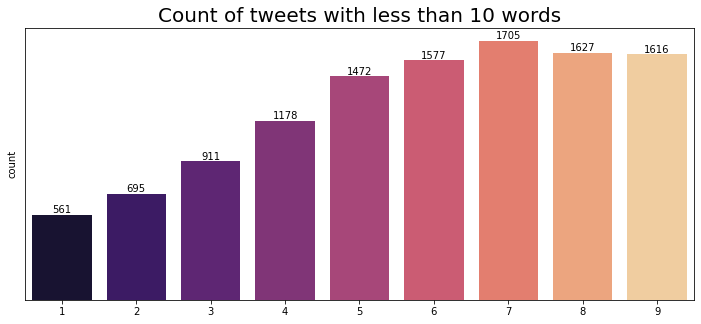

In [24]:
plt.figure(figsize=(12,5))
ax = sns.countplot(x='Text_lemm_word_length', data=twitter_final[twitter_final['Text_lemm_word_length']<10], palette='magma')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

### Plotting for long tweets

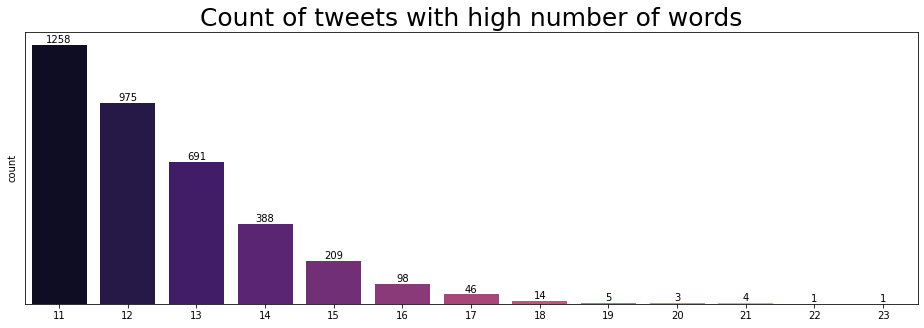

In [25]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='Text_lemm_word_length', data=twitter_final[(twitter_final['Text_lemm_word_length']<=1000) & (twitter_final['Text_lemm_word_length']>10)], palette='magma')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [26]:
perc_short_tweets = len(twitter_final[twitter_final['Text_lemm_word_length']<10])/(len(twitter_final[twitter_final['Text_lemm_word_length']<10]) + len(twitter_final[(twitter_final['Text_lemm_word_length']<=1000) & (twitter_final['Text_lemm_word_length']>10)]))
round(perc_short_tweets,2)

0.75

In [27]:
print("It can be observed that majority of tweets are short consisting of 10 words or less, constituting {:.0%} of tweets in the dataset.".format(round(perc_short_tweets,2)))

It can be observed that majority of tweets are short consisting of 10 words or less, constituting 75% of tweets in the dataset.


# Preprocessing for word n-grams

This preprocessing step is for plotting purposes. The preproccessing method transforms the text columns into BagofWords using CountVectoizer as it is just a simple count of each word that are plotted.

In [28]:
# Instantiating CountVectorizers

# unigram
cv1 = CountVectorizer()

# bigram
cv2 = CountVectorizer(ngram_range=(2,2))

# trigram
cv3 = CountVectorizer(ngram_range=(3,3))

### Unigram

In [29]:
# Unigram for stemmed text
cv1.fit(twitter_final['Text_stem'])

stem_cv1 = cv1.transform(twitter_final['Text_stem'])
stem_cv1_df = pd.DataFrame(stem_cv1.todense(), columns=cv1.get_feature_names_out())

In [30]:
# Unigram for lemmaztized text
cv1.fit(twitter_final['Text_lemm'])

lemm_cv1_racism = cv1.transform(twitter_final['Text_lemm'][twitter_final['Annotation'] == 'racism'])
lemm_cv1_sexism = cv1.transform(twitter_final['Text_stem'][twitter_final['Annotation'] == 'sexism'])
lemm_cv1_racism_df = pd.DataFrame(lemm_cv1_racism.todense(), columns=cv1.get_feature_names_out())
lemm_cv1_sexism_df = pd.DataFrame(lemm_cv1_sexism.todense(), columns=cv1.get_feature_names_out())

### Bigram

In [31]:
# Bigram for stemmed text
cv2.fit(twitter_final['Text_stem'])

stem_cv2 = cv2.transform(twitter_final['Text_stem'])
stem_cv2_df = pd.DataFrame(stem_cv2.todense(), columns=cv2.get_feature_names_out())

In [32]:
# Bigram for lemmaztized text
cv2.fit(twitter_final['Text_lemm'])

lemm_cv2_racism = cv2.transform(twitter_final['Text_lemm'][twitter_final['Annotation'] == 'racism'])
lemm_cv2_sexism = cv2.transform(twitter_final['Text_stem'][twitter_final['Annotation'] == 'sexism'])
lemm_cv2_racism_df = pd.DataFrame(lemm_cv2_racism.todense(), columns=cv2.get_feature_names_out())
lemm_cv2_sexism_df = pd.DataFrame(lemm_cv2_sexism.todense(), columns=cv2.get_feature_names_out())

### Trigram

In [33]:
# Trigram for stemmed text
cv3.fit(twitter_final['Text_stem'])

stem_cv3 = cv3.transform(twitter_final['Text_stem'])
stem_cv3_df = pd.DataFrame(stem_cv3.todense(), columns=cv3.get_feature_names_out())

In [34]:
# Trigram for lemmaztized text
cv3.fit(twitter_final['Text_lemm'])

lemm_cv3_racism = cv3.transform(twitter_final['Text_lemm'][twitter_final['Annotation'] == 'racism'])
lemm_cv3_sexism = cv3.transform(twitter_final['Text_stem'][twitter_final['Annotation'] == 'sexism'])
lemm_cv3_racism_df = pd.DataFrame(lemm_cv3_racism.todense(), columns=cv3.get_feature_names_out())
lemm_cv3_sexism_df = pd.DataFrame(lemm_cv3_sexism.todense(), columns=cv3.get_feature_names_out())

# Word n-gram Analysis

For the purpose of plotting commonly observed word n-grams without significant overlaps, the following will only plot lemmatized texts.

### Unigram

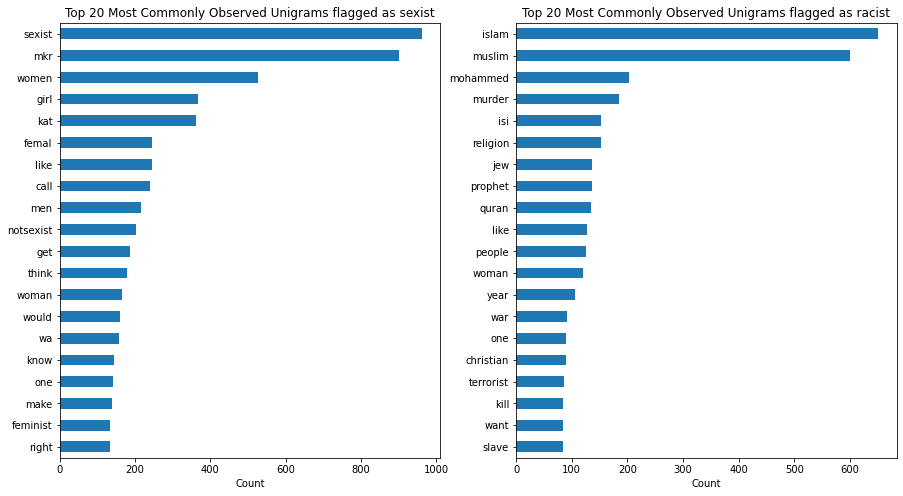

In [36]:
# Plotting the top 20 unigram of lemmatized texts
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize= (15,8))
ax = ax.ravel()

plt.subplots_adjust(hspace = 0.1)

# Setting up plot for sexism
lemm_cv1_sexism_df.sum().sort_values(ascending=True).tail(20).plot(kind='barh',ax = ax[0])
ax[0].set_title('Top 20 Most Commonly Observed Unigrams flagged as sexist')
ax[0].set_xlabel('Count')

# Setting up plot for racism
lemm_cv1_racism_df.sum().sort_values(ascending=True).tail(20).plot(kind='barh',ax = ax[1])
ax[1].set_title('Top 20 Most Commonly Observed Unigrams flagged as racist')
ax[1].set_xlabel('Count');

It can be observed that unigrams from tweets flagged as racist are largely centred around females. mkr stands for My Kitchen Rules, a reality cooking competition, and its hashtag #mkr contains many sexist comments on Twitter.

Those flagged as racist have significant anti-religious sentiments, primarily centered around the Abrahamic faiths (Islam, Christianity, and Judaism), with references to fundamentalists and extremists ('ISI' or ISIS, lemmatized/stemmed the second 's' away, and 'terrorist').

### Bigram

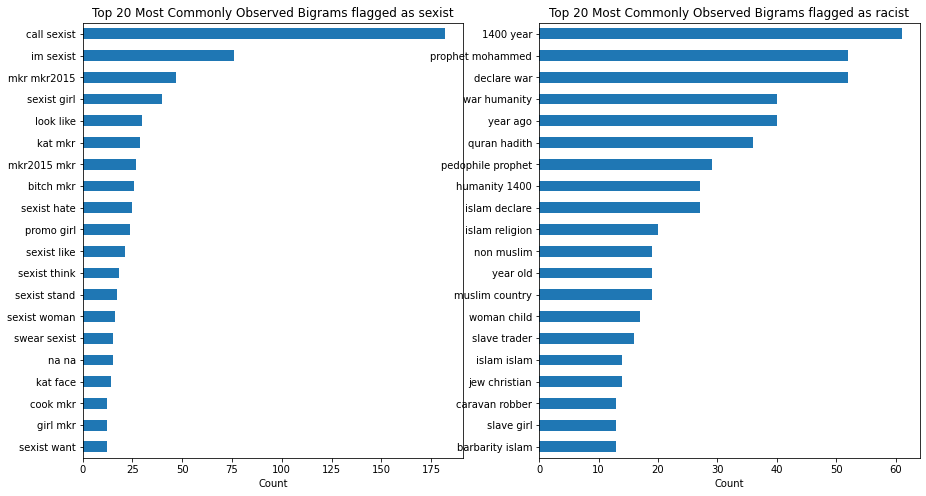

In [37]:
# Plotting the top 20 bigram of lemmatized texts
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize= (15,8))
ax = ax.ravel()

plt.subplots_adjust(hspace = 0.1)

# Setting up plot for sexism
lemm_cv2_sexism_df.sum().sort_values(ascending=True).tail(20).plot(kind='barh',ax = ax[0])
ax[0].set_title('Top 20 Most Commonly Observed Bigrams flagged as sexist')
ax[0].set_xlabel('Count')

# Setting up plot for racism
lemm_cv2_racism_df.sum().sort_values(ascending=True).tail(20).plot(kind='barh',ax = ax[1])
ax[1].set_title('Top 20 Most Commonly Observed Bigrams flagged as racist')
ax[1].set_xlabel('Count');

Commonly observed bigrams from tweets flagged as sexist are still centered around My Kitchen Rules, and many tweets contain the word 'sexist'.

At this level, it can be seen that the 2 most common themes are about calling out or recognizing sexism. Though upon further investigation, these tweets frequently contain phrases such as 'call me sexist but... (follows by something sexist)', or 'i'm not a sexist but... (follows by something sexist)'.

Commonly observed bigrams from tweets flagged as racist show similar themes as seen in unigrams.

Interestingly, the bigram '1400 year' and 'humanity 1400' are now highlighted when previously in unigrams, neither of the terms '1400' and 'humanity' are highlighted, alongside the lack of mentions of 'isi' (ISIS) despite it being a frequently observed unigram. Also, there are mentions of girls which are not seen in the unigrams. 

However, at the bigram level, there is not much information about the references to '1400 year', i.e. what happened around year 1400 or what happened about 1400 years ago? Based on the top few frequently observed bigrams, a guess can be made about some declaration of war at that point in history.

### Trigram

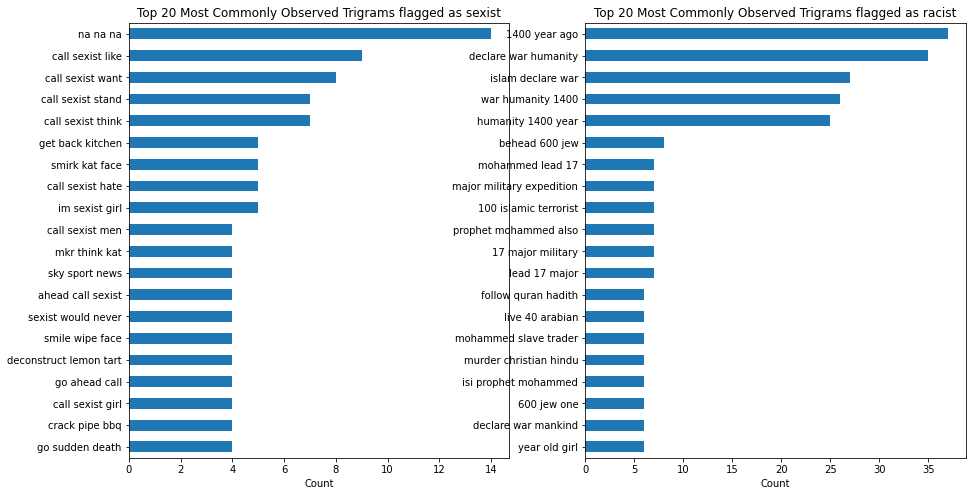

In [38]:
# Plotting the top 20 bigram of lemmatized texts
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize= (15,8))
ax = ax.ravel()

plt.subplots_adjust(hspace = 0.1)

# Setting up plot for sexism
lemm_cv3_sexism_df.sum().sort_values(ascending=True).tail(20).plot(kind='barh',ax = ax[0])
ax[0].set_title('Top 20 Most Commonly Observed Trigrams flagged as sexist')
ax[0].set_xlabel('Count')

# Setting up plot for racism
lemm_cv3_racism_df.sum().sort_values(ascending=True).tail(20).plot(kind='barh',ax = ax[1])
ax[1].set_title('Top 20 Most Commonly Observed Trigrams flagged as racist')
ax[1].set_xlabel('Count');

Commonly observed trigrams from tweets flagged as sexist see that the words 'sexist' and 'mkr' are still dominant. 

With more granularity, the 'call sexist' bigrams is now split into more variants but these variants do not give any more information about those tweets seen in the bigrams.

Commonly observed trigrams from tweets flagged as racist gives us more certainty about what happened about 1400 years ago as compared to bigrams.

Based on the results, it seems that 1400 years ago, there was some declaration of war on humanity. There is more information about the treatment of Jews (beheadment).

Interestingly, there is the first mention of a non-Abrahamic faith in a tweet flagged as racist, i.e. Hinduism.

# Removing Unneccessary Columns

This is done as the dataset will be exported and used for the preprocessing and EDA of character n-grams.

In [39]:
twitter_final = twitter_final.drop(columns = ['Text_stem_length','Text_lemm_length','length_multiple','Text_lemm_word_length'])

# Exporting Dataset

In [44]:
twitter_final.to_csv('../Capstone/data/twitter_final2.csv', index = False)